In [ ]:
!git clone https://github.com/CubiCasa/CubiCasa5k

Cloning into 'CubiCasa5k'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 120 (delta 43), reused 37 (delta 35), pack-reused 52
Receiving objects: 100% (120/120), 62.49 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd CubiCasa5k/

/content/CubiCasa5k


In [ ]:
!ls

 create_lmdb.py			      eval.py	   requirements.txt
 data				      floortrans   runs_cubi
'Difference in Room Annotation.pdf'   LICENSE	   samples.ipynb
 Dockerfile			      README.md    train.py


In [ ]:
from zipfile import ZipFile
# file = "/content/drive/MyDrive/cubicasa5k.zip"
file = "/content/drive/MyDrive/cubicasa5k.zip"
with ZipFile(file, 'r') as zip:
  zip.printdir()

  # extracting all the files
  print('Extracting all the files now...')
  zip.extractall() # 这个是解压到了工作目录里
  print('finished!')

流式输出内容被截断，只能显示最后 5000 行内容。
cubicasa5k/high_quality_architectural/4014/F1_original.png 2018-07-14 14:45:52       472153
cubicasa5k/high_quality_architectural/4014/model.svg 2019-01-23 15:49:34        71189
cubicasa5k/high_quality_architectural/14296/   2018-12-17 11:05:32            0
cubicasa5k/high_quality_architectural/14296/F1_scaled.png 2018-12-04 21:06:48       751103
cubicasa5k/high_quality_architectural/14296/F1_original.png 2018-12-04 21:06:48       648064
cubicasa5k/high_quality_architectural/14296/model.svg 2019-01-23 15:49:34        62566
cubicasa5k/high_quality_architectural/14295/   2018-12-17 11:05:32            0
cubicasa5k/high_quality_architectural/14295/F2_scaled.png 2018-12-04 21:06:46      1022447
cubicasa5k/high_quality_architectural/14295/F1_scaled.png 2018-12-04 21:06:42      1022447
cubicasa5k/high_quality_architectural/14295/F1_original.png 2018-12-04 21:06:42       909396
cubicasa5k/high_quality_architectural/14295/F2_original.png 2018-12-04 21:06:46       909

In [ ]:
!pip install svgpathtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib==3.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


In [ ]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
#  discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

/content/CubiCasa5k/floortrans/loaders/svg_utils.py:565: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direction is 'H':
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4


In [ ]:
discrete_cmap() # 虽然这个跑了之后会报错，但是还是必须要跑的，否则下面画图的时候会出问题

In [ ]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [ ]:
data_folder = '/content/CubiCasa5k/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)

In [ ]:
print(data_iter)

In [ ]:
# Setup Model
model = get_model('hg_furukawa_original', 51) # 加载模型

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('/content/drive/MyDrive/model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

Model loaded.


#Example 1

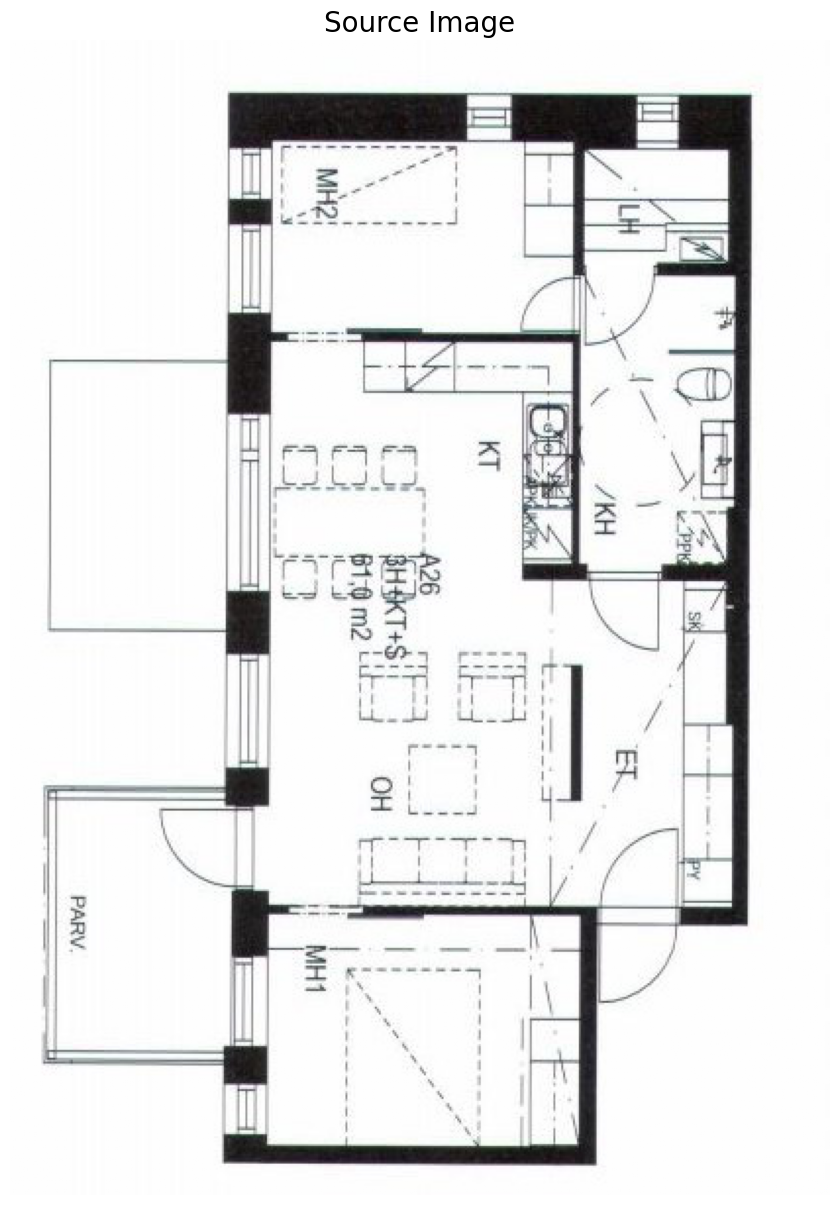

In [ ]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(15,15))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= data_folder+folder+"model.svg", width=800)

# Parsed labels

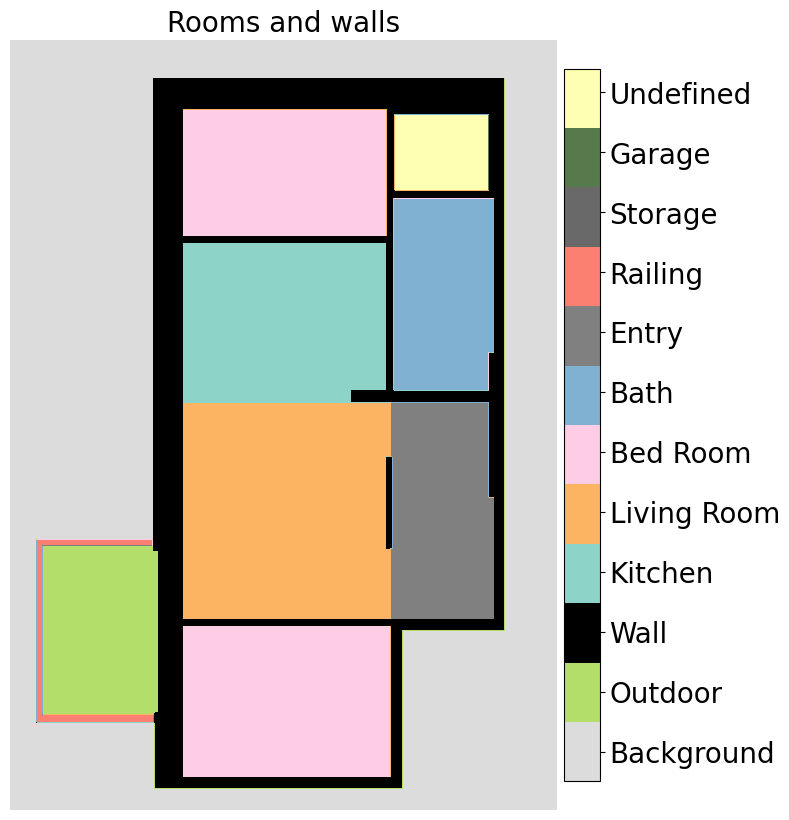

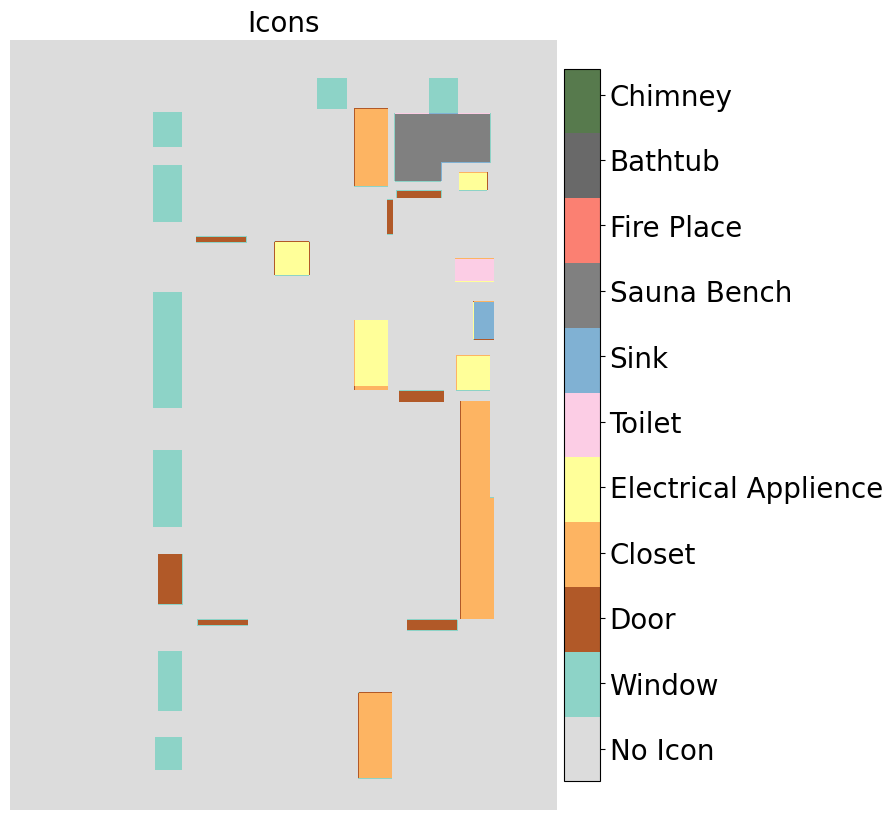

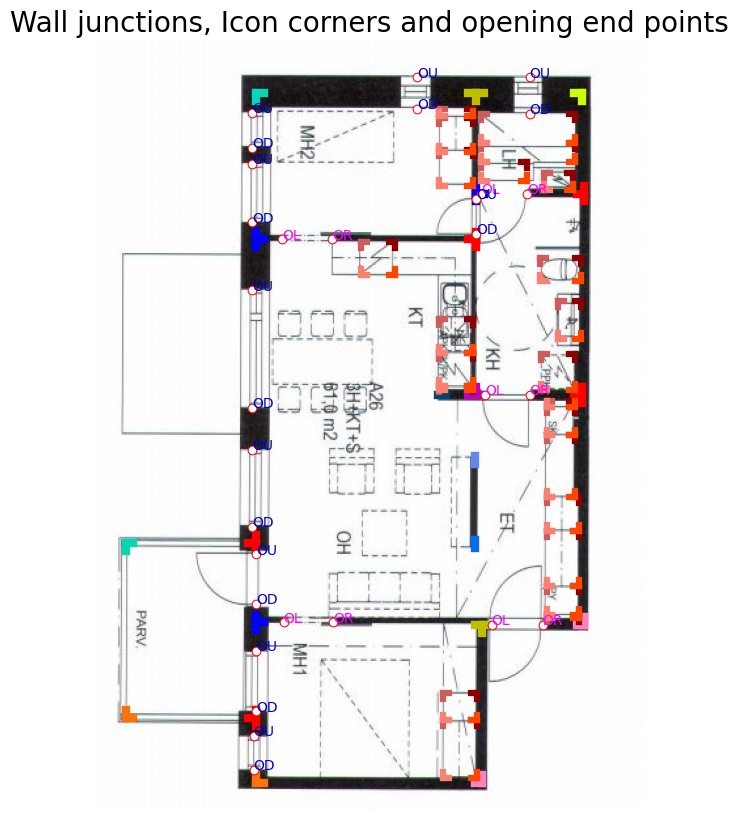

In [ ]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20) #墙壁连接处、图标角和开口端点
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

#Segmentation prediction

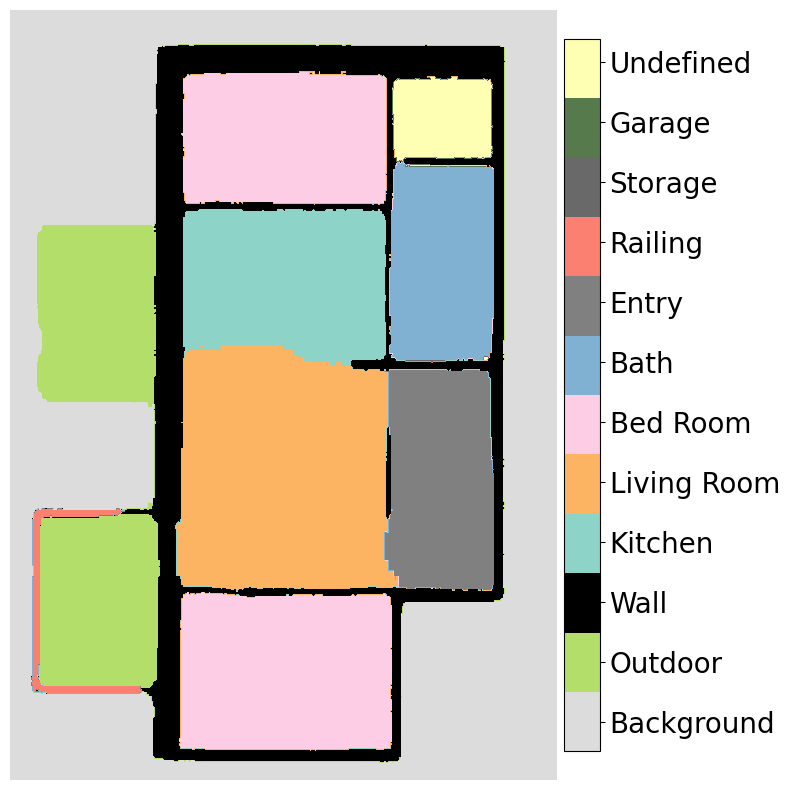

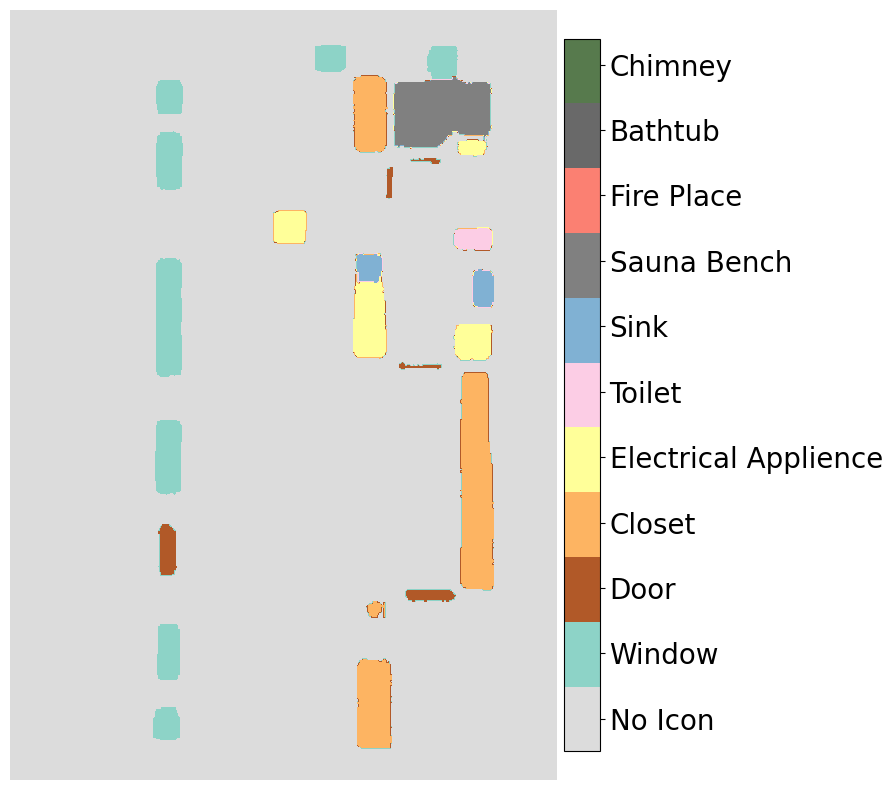

In [ ]:
with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

#Post-Processing

In [ ]:
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

IndexError: ignored